In [24]:
# Imports
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from progressbar import ProgressBar

import torch

tensor([0.0088], grad_fn=<AddBackward0>)


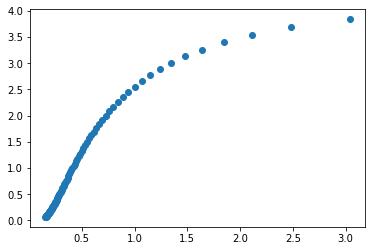

In [2]:
#first working prototype
w1 = torch.autograd.Variable(torch.FloatTensor([4]),requires_grad = True)
w2 = torch.autograd.Variable(torch.FloatTensor([4]),requires_grad = True)
w1_array = np.zeros(100)
w2_array = np.zeros(100)
for i in range(100):
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    external_grad = torch.tensor([1.])
    L = w1**3+w2**2
    L.backward(external_grad)
    with torch.no_grad():
        w1 = w1 - w1.grad*0.02
        w2 = w2 - w2.grad*0.02
    w1_array[i] = torch.Tensor.numpy(w1)
    w2_array[i] = torch.Tensor.numpy(w2)

plt.scatter(w1_array,w2_array)
print(L)

In [3]:
#autoencoder

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
A = unpickle('data_batch_2')

In [6]:
image_set = list(A.items())[2][1]

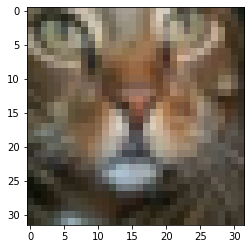

In [7]:
im2 = np.zeros((32,32,3))
R = image_set[5,:1024].reshape(32,32)
G = image_set[5,1024:2048].reshape(32,32)
B = image_set[5,2048:].reshape(32,32)
for i in range(32):
    for j in range (32):
        im2[i,j] = np.array([R[i,j],G[i,j],B[i,j]])
im2 = im2.astype('int')
plt.imshow(im2)

In [8]:
image_set_grayscale = 0.2126*image_set.reshape(10000,3,1024)[:,0,:] + 0.7152*image_set.reshape(10000,3,1024)[:,1,:] + 0.0722*image_set.reshape(10000,3,1024)[:,2,:]
image_set_grayscale = (image_set_grayscale.T).astype('float32')
image_set_grayscale = torch.tensor(image_set_grayscale)/256

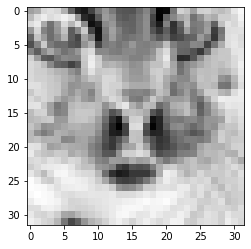

In [9]:
plt.imshow(image_set_grayscale[:,5].reshape(32,32),cmap='Greys')

In [10]:
#autoencoder example 1:
w1 = torch.autograd.Variable(torch.torch.randn((25,1024))/1024,requires_grad = True)
w2 = torch.autograd.Variable(torch.torch.randn((1024,25))/1024,requires_grad = True)
b = torch.autograd.Variable(torch.torch.randn(1,25),requires_grad = True)
loss_list = np.zeros(1000)
m = torch.nn.ReLU()

for i in range(10):
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    b.requires_grad_(True)
    a = m(torch.matmul(w1,image_set_grayscale)+b.T)
    y = torch.matmul(w2,a)
    L = torch.sum(torch.sum((image_set_grayscale - y)**2))/10000
    L.backward()
    with torch.no_grad():
        w1 = w1 - w1.grad*0.002
        w2 = w2 - w2.grad*0.002
        b = b - b.grad*0.002
    loss_list[i] = L

In [42]:
#example code 2: more efficient version
class network1():
    def __init__(self,image_dim = 1024,hid_dim = 25):
        self.in_dim = image_dim
        self.out_dim = hid_dim
        dropout = nn.Dropout(p=0.5)
    def forward(image_set,w1,w2,b):
        a = m(torch.matmul(w1,image_set_grayscale)+b.T)
        y = torch.matmul(w2,a)
        L = torch.sum(torch.sum((image_set_grayscale - y)**2))/10000 + 10**-5*torch.sum(torch.abs(a))
        return L

image_dim = 1024
hid_dim = 128
w1 = torch.autograd.Variable(torch.torch.rand((hid_dim,image_dim))/image_dim*5,requires_grad = True)
w2 = torch.autograd.Variable(torch.torch.rand((image_dim,hid_dim))/image_dim*5,requires_grad = True)
b = torch.autograd.Variable(torch.torch.randn(1,hid_dim),requires_grad = True)

dropout = torch.nn.Dropout(p=0.1)
m = torch.nn.ReLU()
optimizer = torch.optim.SGD([w1,w2,b], 0.002)

loss_list = []
for i in range(5000):
    L = network1.forward(image_set_grayscale,w1,w2,b)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    L1 = L.detach().numpy().copy()
    loss_list.append(L1)

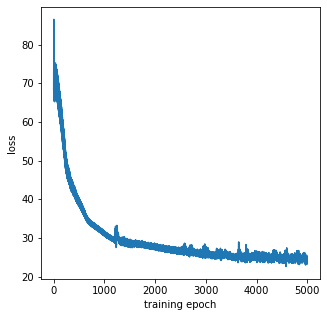

23.31025


In [43]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(np.array(loss_list).reshape(-1))
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.show()
print(loss_list[-1])

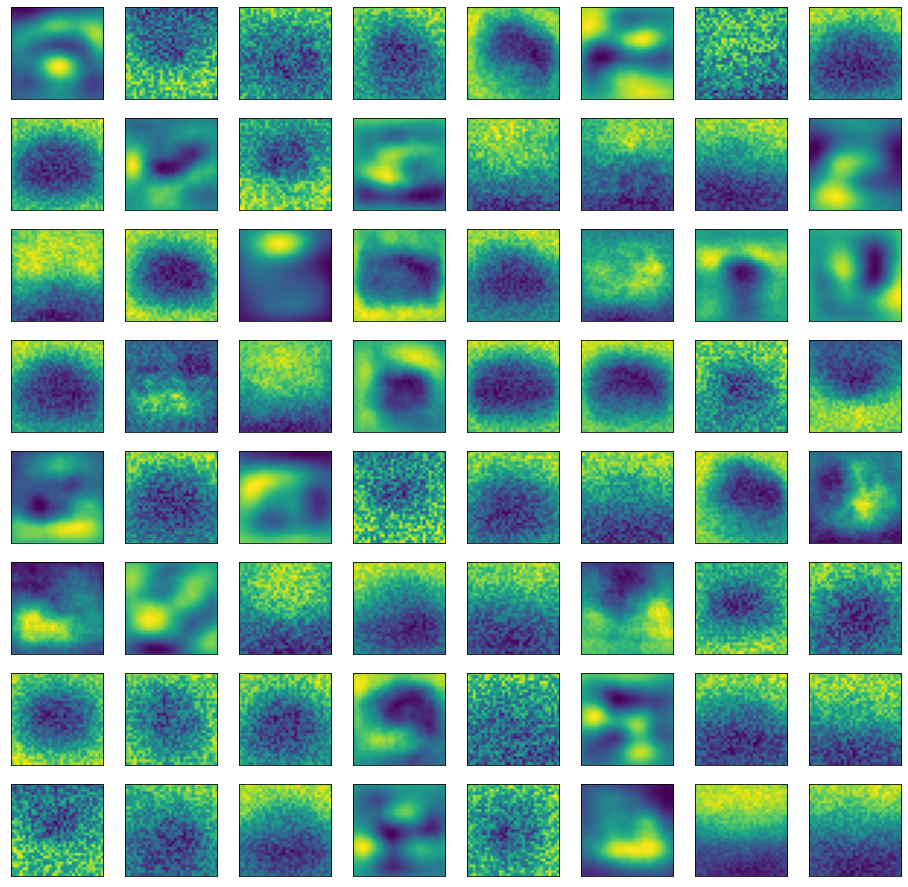

In [48]:
plt.rcParams["figure.figsize"] = (16,16)
fig,axs = plt.subplots(8,8)
for i in range(8):
    for j in range(8):
        ax = axs[i,j]
        ax.imshow(w2[:,int(8*i+j)].detach().numpy().reshape((32,32)))
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

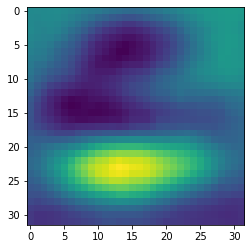

In [55]:
recons = torch.matmul(w2,m(torch.matmul(w1,image_set_grayscale)+b.T))
plt.rcParams["figure.figsize"] = (4,4)
plt.imshow(recons[:,3].detach().numpy().reshape(32,32))
plt.show()

In [14]:
#whitening and pre-processing
image_set_zero_mean = (image_set_grayscale.T - torch.mean(image_set_grayscale,axis=1)).T

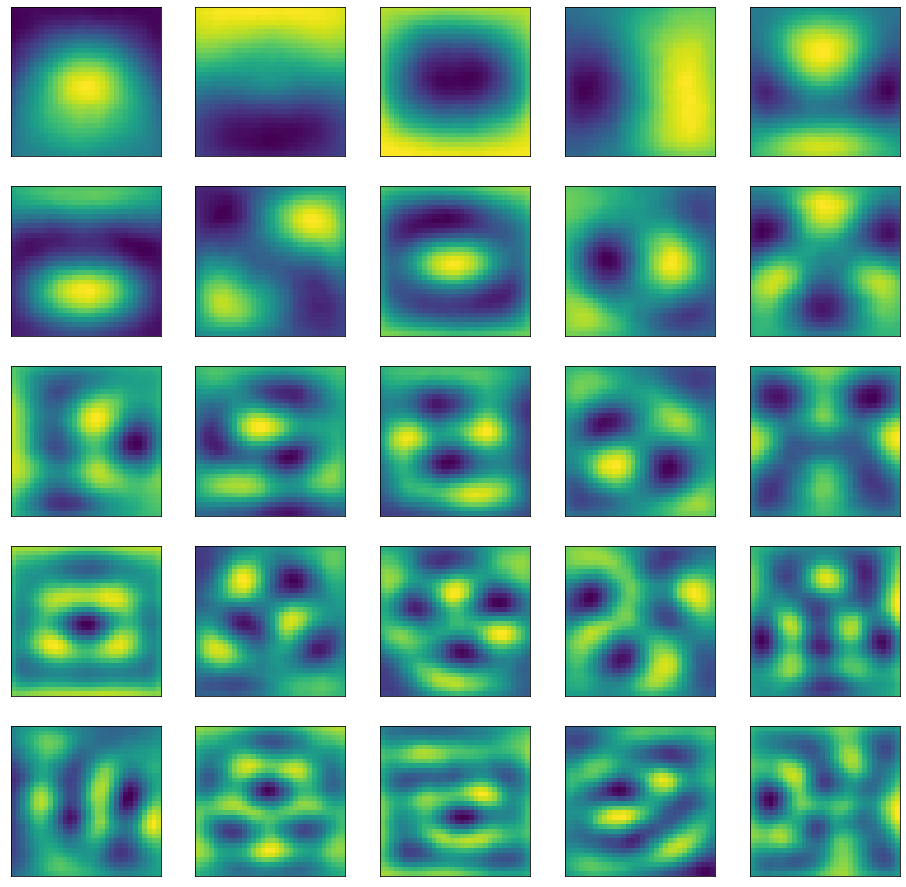

In [15]:
#PCA
L,V = torch.linalg.eig(torch.cov(image_set_zero_mean))
plt.rcParams["figure.figsize"] = (16,16)
fig,axs = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        ax.imshow(torch.real(V[:,int(5*i+j)]).detach().numpy().reshape((32,32)))
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

In [16]:
#whitening
L,V = torch.linalg.eig(torch.cov(image_set_zero_mean))
W = torch.matmul(torch.diag(L**-0.5),V.T)
image_set_white = torch.matmul(torch.real(W),image_set_zero_mean)
torch.cov(image_set_white)

tensor([[ 1.0000e+00, -1.6710e-07,  1.3710e-07,  ...,  1.6428e-06,
         -7.9611e-06,  1.5616e-06],
        [-1.6710e-07,  1.0000e+00, -3.3382e-08,  ..., -3.2424e-06,
         -4.1578e-06,  3.1298e-07],
        [ 1.3710e-07, -3.3382e-08,  1.0000e+00,  ...,  7.6523e-07,
          1.0158e-06,  1.0287e-06],
        ...,
        [ 1.6428e-06, -3.2424e-06,  7.6523e-07,  ...,  1.0003e+00,
          2.7179e-03,  3.1281e-02],
        [-7.9611e-06, -4.1578e-06,  1.0158e-06,  ...,  2.7179e-03,
          9.9996e-01, -1.3574e-02],
        [ 1.5616e-06,  3.1298e-07,  1.0287e-06,  ...,  3.1281e-02,
         -1.3574e-02,  9.9979e-01]])